In [63]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scripts.processing import general_processing
import librosa
import random
from scripts.audio_importer import Clip

In [64]:
audio_dt = pd.read_pickle('data/imported_audio_original.pkl')
audio_dt = audio_dt[audio_dt.esc10].reset_index(drop=True)

In [65]:
audio_dt = general_processing(audio_dt)

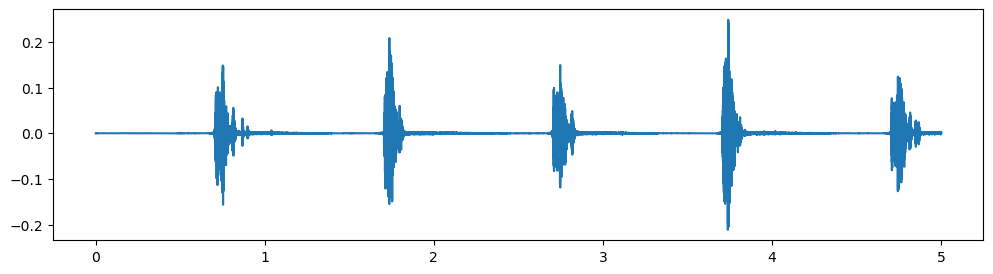

In [66]:

with audio_dt.audio.iloc[23].audio as audio:
    # print(audio.RATE)
    plt.figure(figsize=(12, 3))
    plt.plot(np.arange(len(audio.raw))/44100, audio.raw)


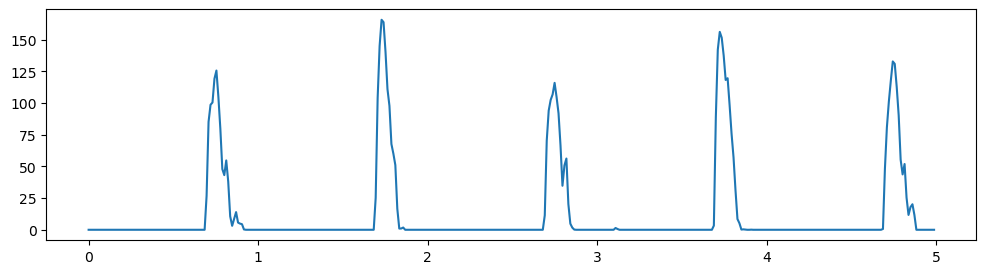

In [67]:
plt.figure(figsize=(12, 3))
plt.plot((np.arange(audio_dt.iloc[23].audio.x_df['mfcc_1'].shape[0])/audio_dt.iloc[23].audio.x_df['mfcc_1'].shape[0]) * 5,
         audio_dt.iloc[23].audio.x_df['mfcc_1'])

In [68]:
list(audio_dt.iloc[23].audio.x_df.filter(regex='zcr').columns)

['zcr']

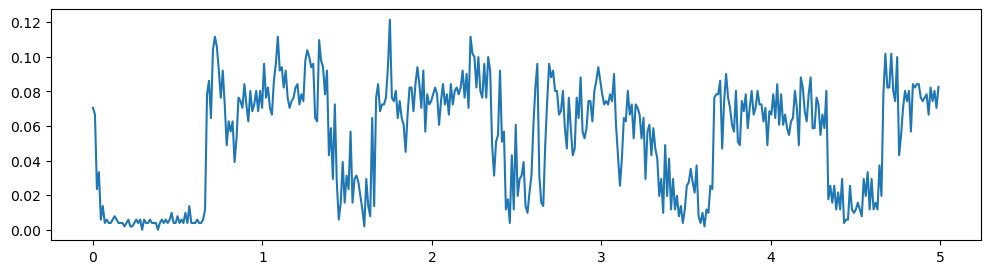

In [69]:
plt.figure(figsize=(12, 3))
plt.plot((np.arange(audio_dt.iloc[23].audio.x_df['mfcc_1'].shape[0])/audio_dt.iloc[23].audio.x_df['mfcc_1'].shape[0]) * 5,
         audio_dt.iloc[23].audio.x_df['zcr'])

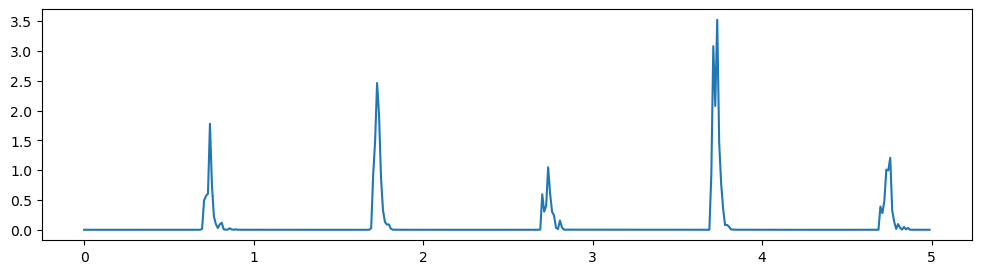

In [70]:
plt.figure(figsize=(12, 3))
plt.plot((np.arange(audio_dt.iloc[23].audio.x_df['mfcc_1'].shape[0])/audio_dt.iloc[23].audio.x_df['mfcc_1'].shape[0]) * 5,
         audio_dt.iloc[23].audio.x_df['energy'])

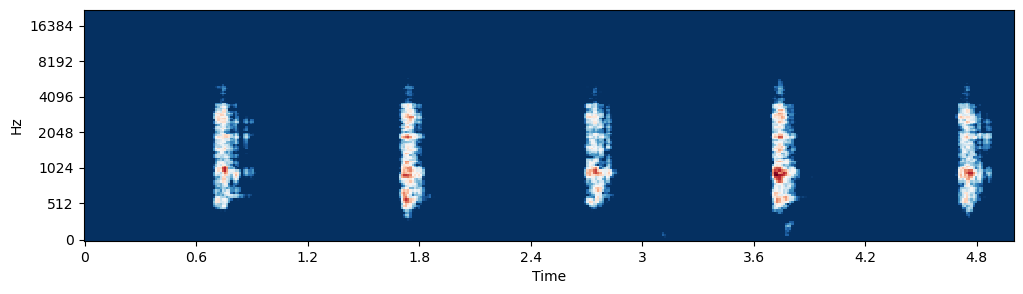

In [71]:
plt.figure(figsize=(12, 3))
librosa.display.specshow(audio_dt.iloc[23].audio.logamplitude, sr=audio_dt.iloc[23].audio.RATE, x_axis='time', y_axis='mel', cmap='RdBu_r')

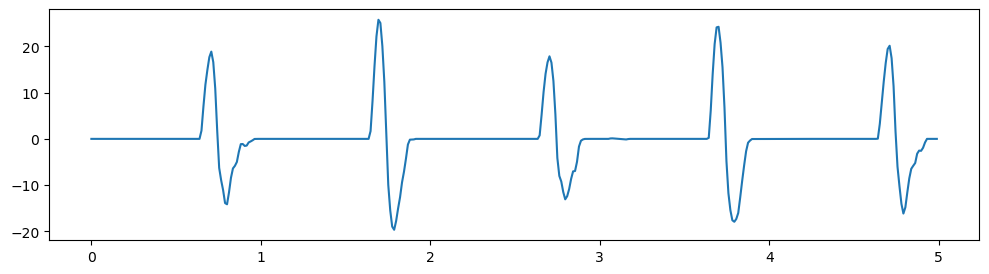

In [72]:
plt.figure(figsize=(12, 3))
plt.plot((np.arange(audio_dt.iloc[23].audio.x_df['mfcc_1'].shape[0])/audio_dt.iloc[23].audio.x_df['mfcc_1'].shape[0]) * 5,
         audio_dt.iloc[23].audio.x_df['delta_1'])

## Plot the followings:
- Historgram of each coefficient for each class
- Random plot of N classes
- Check if we have a balanced sample
- 

<AxesSubplot: xlabel='category'>

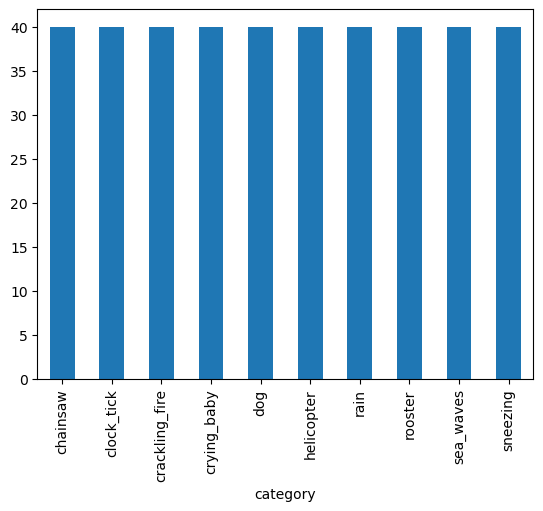

In [74]:
audio_dt.groupby('category').size().plot(kind='bar')

In [75]:
dict_category = {}
for i, row in audio_dt.iterrows():
    try:
        dict_category[row['category']]
    except:
        dict_category[row['category']] = pd.DataFrame()
    
    dict_category[row['category']] = pd.concat([dict_category[row['category']], row['audio'].x_df])

In [76]:
dict_category.keys()

dict_keys(['clock_tick', 'dog', 'rooster', 'chainsaw', 'rain', 'sneezing', 'crying_baby', 'helicopter', 'sea_waves', 'crackling_fire'])

In [77]:
# for k, v in dict_category.items():
#     v.plot.density(subplots=True, layout=(2,7), figsize=(18, 6), sharex=False, sharey=False, title=k)
#     plt.tight_layout()

## This plot does not really show me a lot

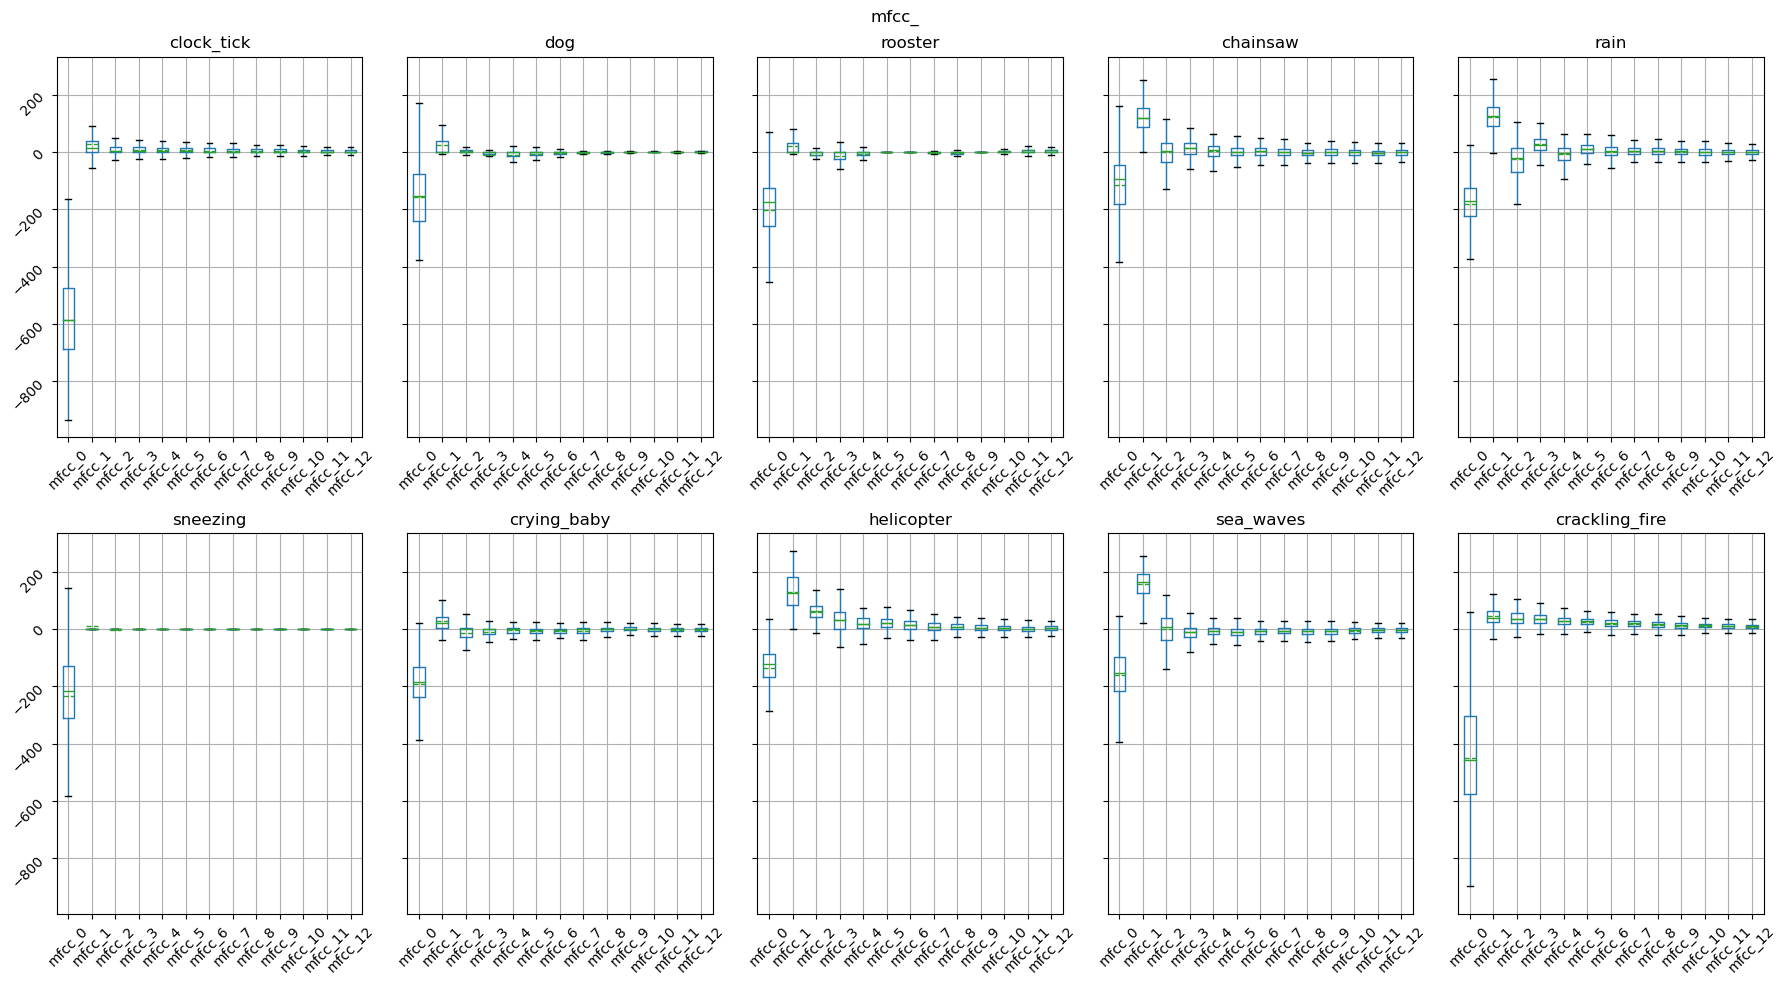

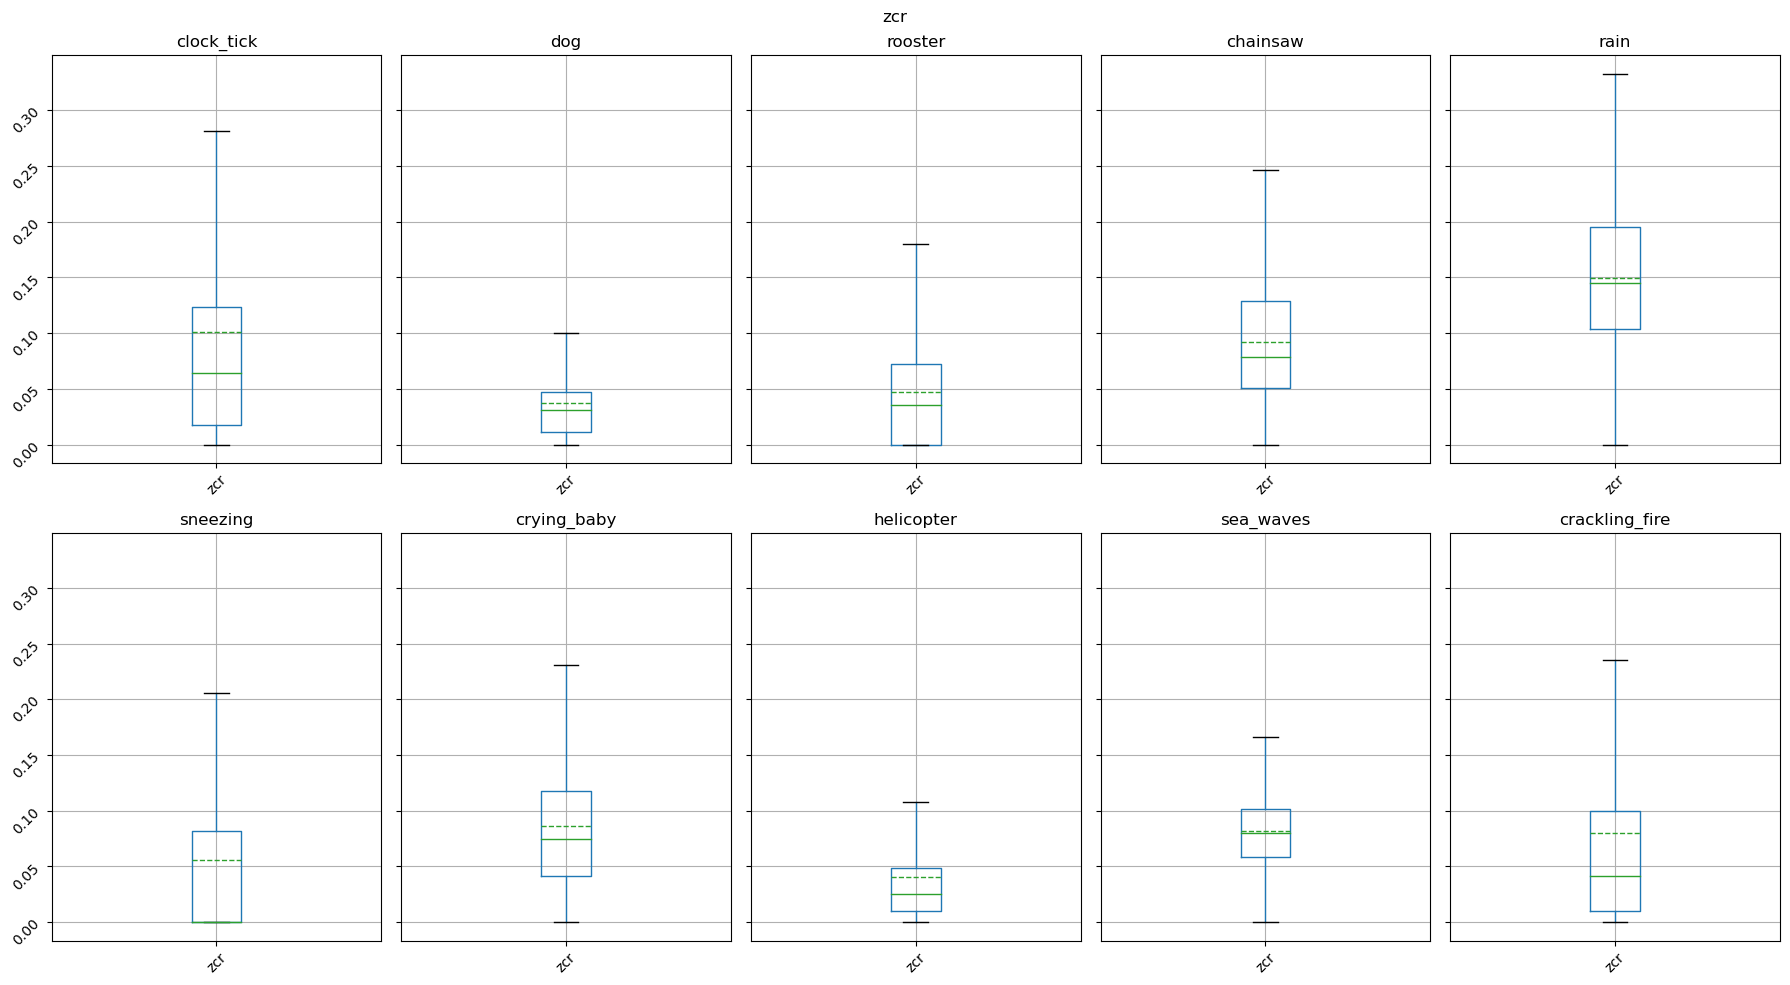

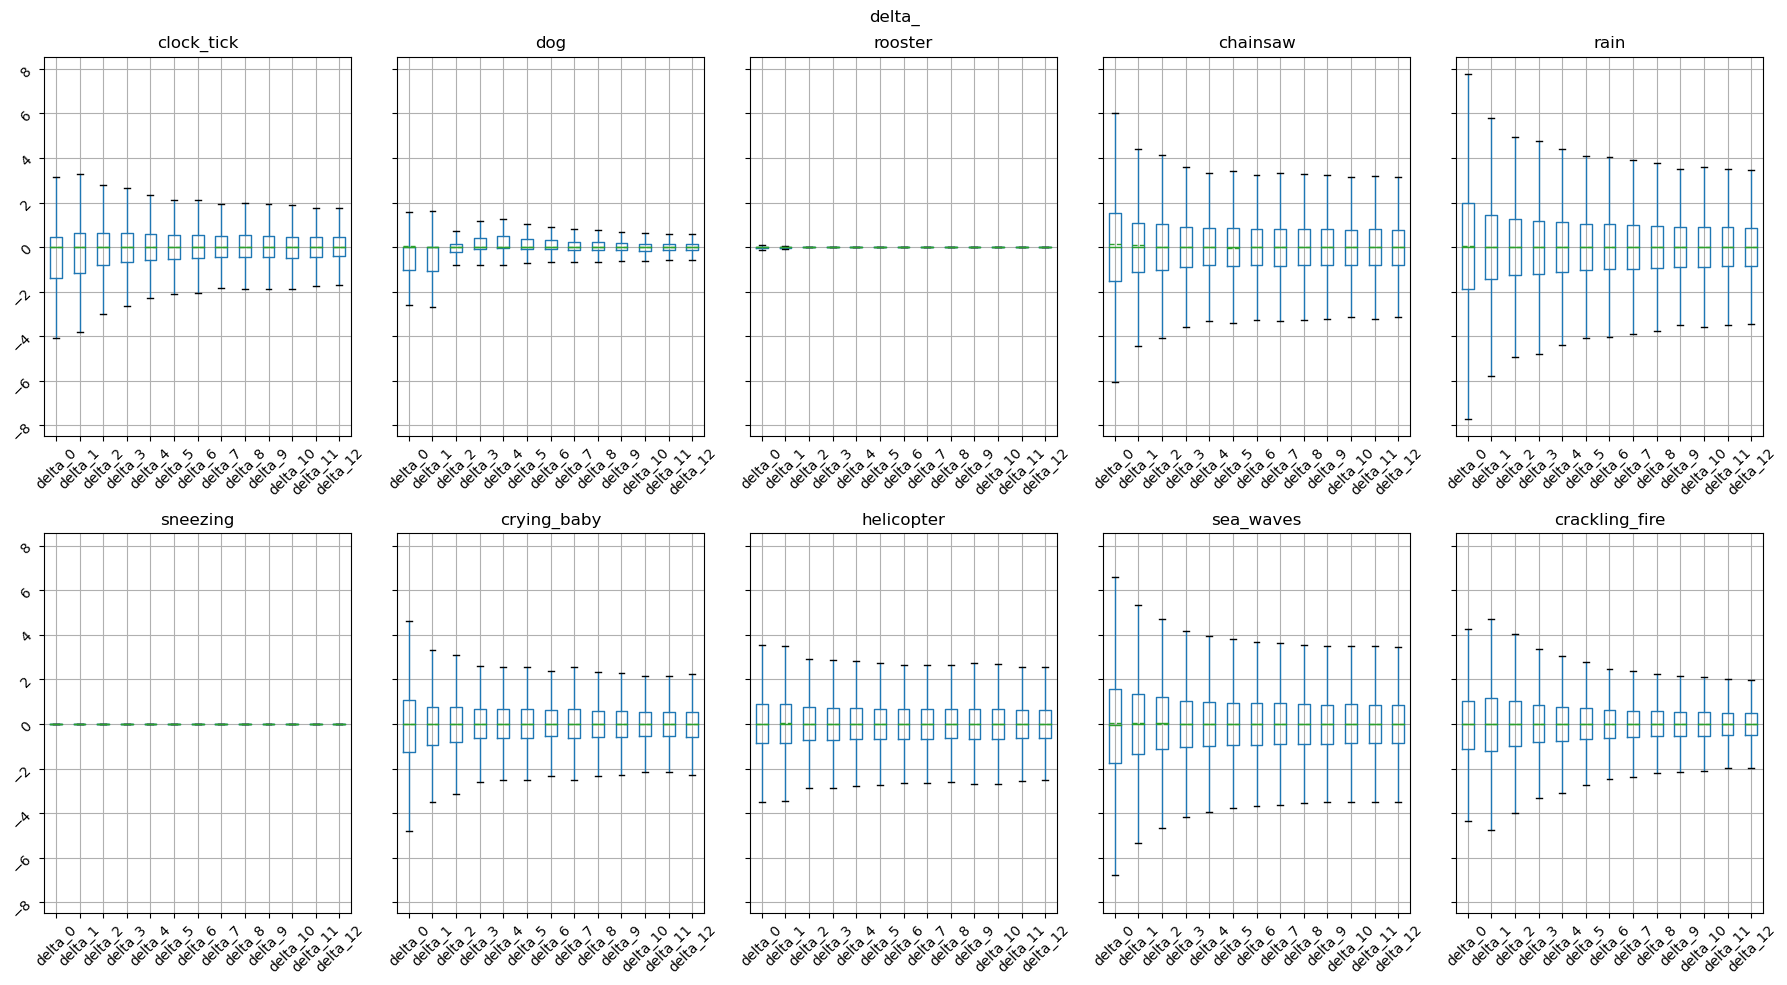

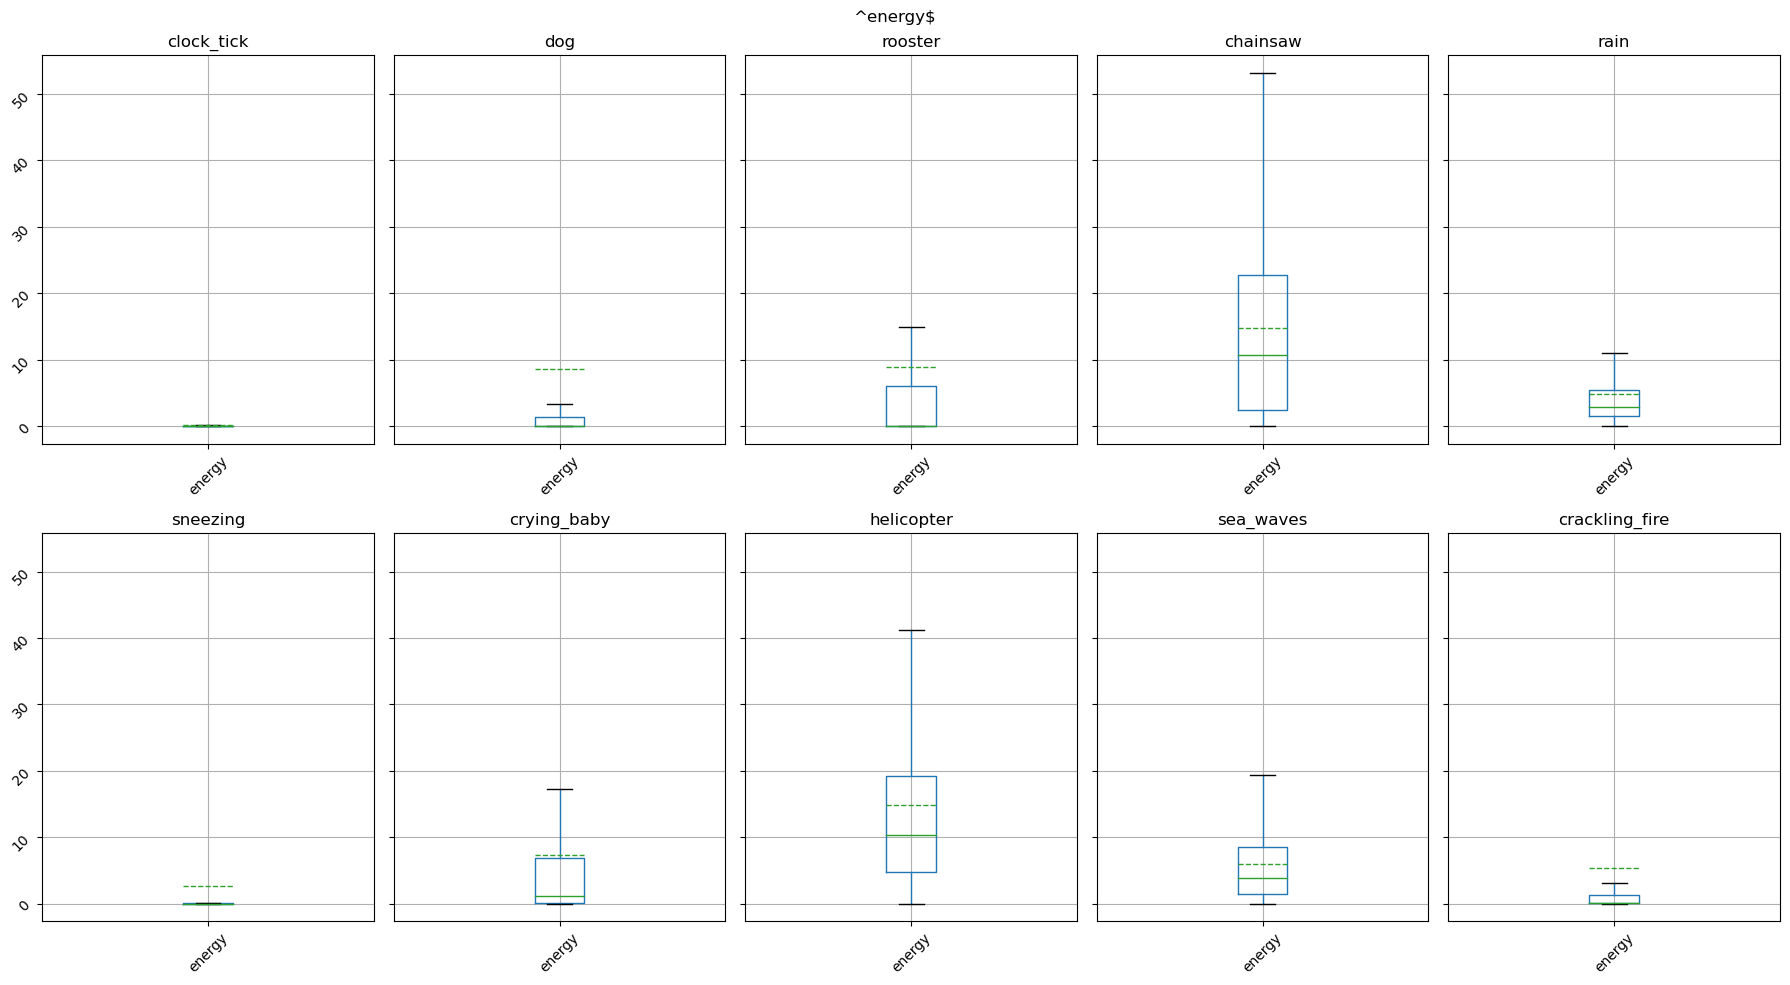

In [78]:
for var_type in ['mfcc_', 'zcr', 'delta_', '^energy$']:
    fig, axs = plt.subplots(int(np.ceil(len(list(dict_category.keys()))/5)), 5, figsize=(18, 10), sharey=True)
    ax_flatten = axs.flatten()
    for i, k in enumerate(dict_category.keys()):
        var_selection = dict_category[list(dict_category.keys())[0]].filter(regex=var_type).columns
        # var_selection = [var for var in dict_category[list(dict_category.keys())[0]].columns if var_type in var]
        dict_category[k][var_selection[:13]].boxplot(ax=ax_flatten[i], showfliers=False, showmeans=True, meanline=True)
        ax_flatten[i].title.set_text(k)
        ax_flatten[i].tick_params(labelrotation=45)

    plt.suptitle(var_type)
    plt.tight_layout()
   


From this plot we can already see that for some classes some frequencies are not very important, I am also doubting to take into consideration the first mfcc since it is the loudness coefficient (and this I guess it depends on how close the microphone is I guess)

In [86]:
dict_coeff = {}
for k, v in dict_category.items():
    for coeff in v.filter(regex='^delta_').columns[:13]:
        try:
            dict_coeff[coeff]
        except:
            dict_coeff[coeff]=pd.DataFrame()

        coeff_output = v[[coeff]].rename(columns={coeff: k}).reset_index(drop=True)
        dict_coeff[coeff] = pd.concat([dict_coeff[coeff], coeff_output], axis=1)

In [87]:
axs.shape

(3, 5)

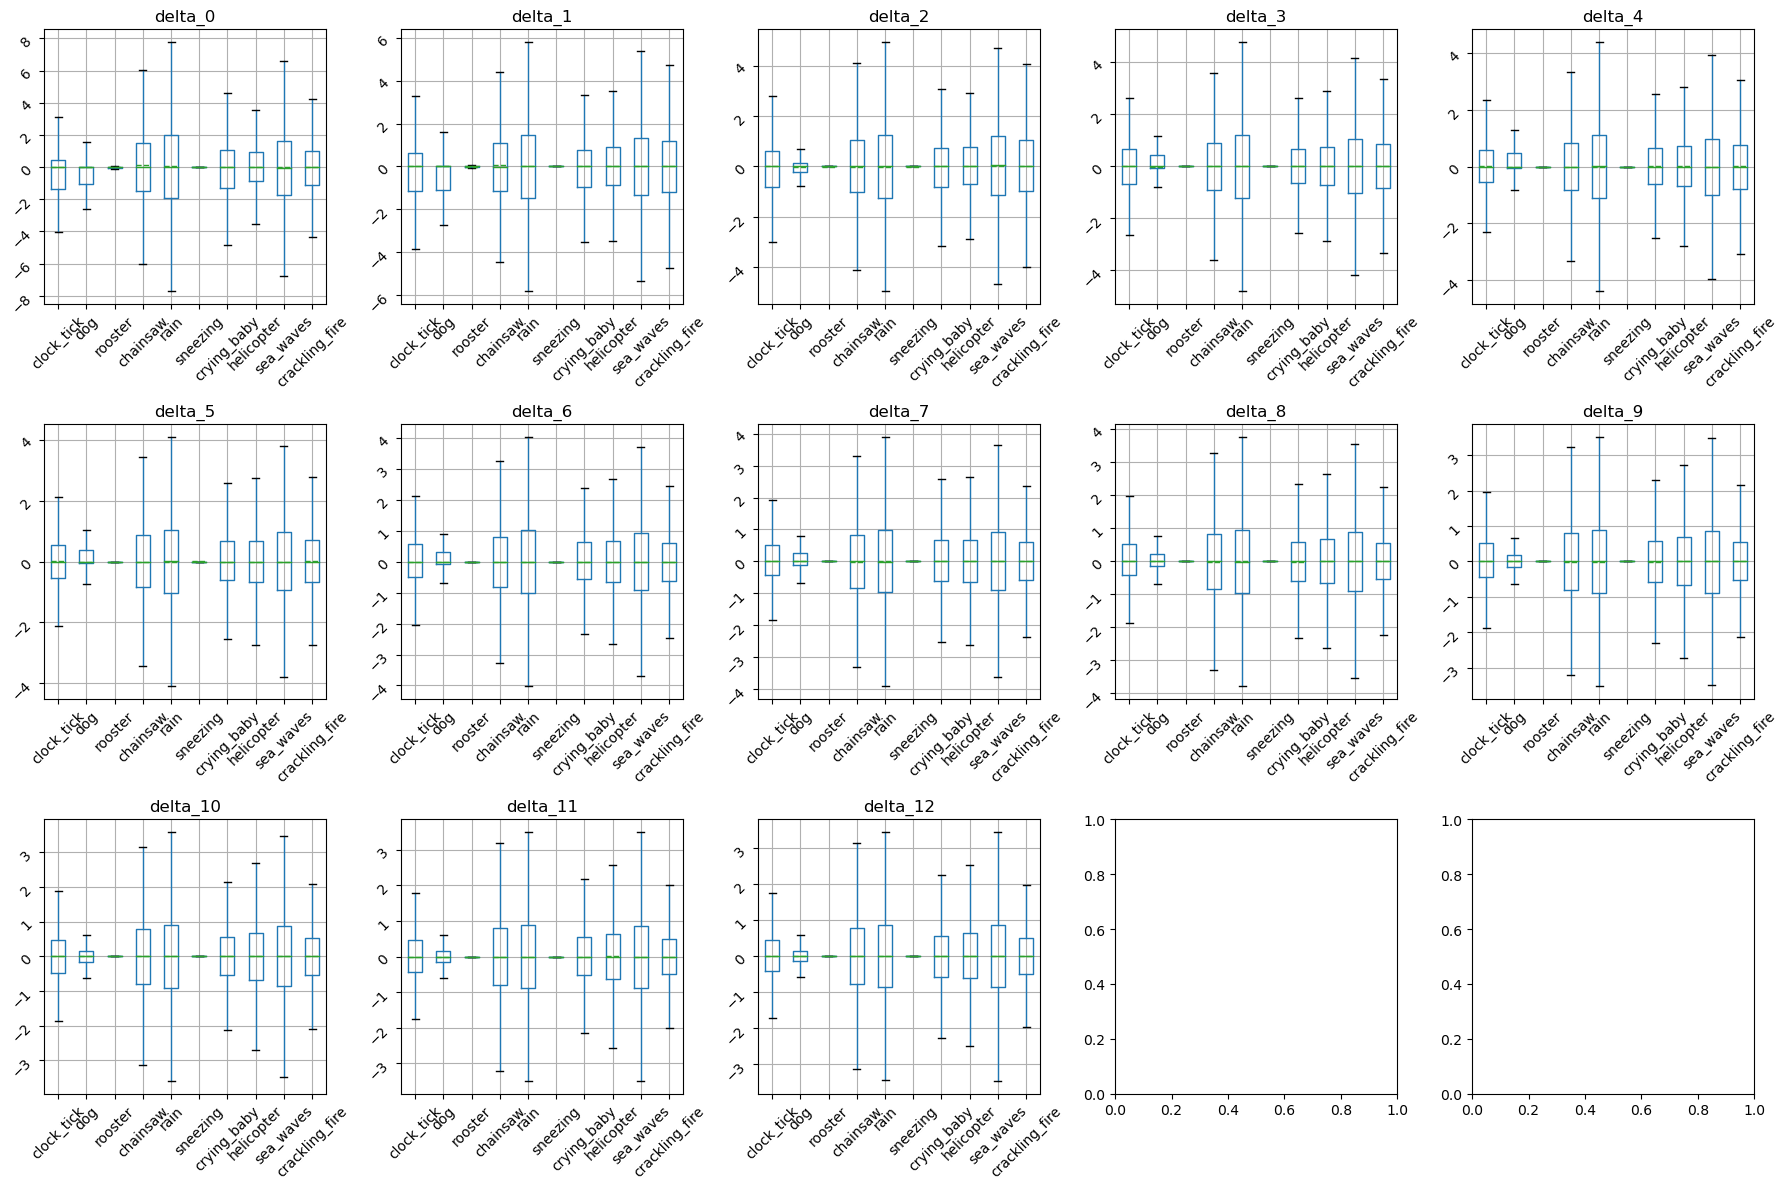

In [88]:
fig, axs = plt.subplots(3, 5, figsize=(18, 12), sharey=False)
try:
    ax_flatten = axs.flatten()
except:
    ax_flatten = [axs]
for i, k in enumerate(dict_coeff.keys()):
    dict_coeff[k].boxplot(ax=ax_flatten[i], showfliers=False, showmeans=True, meanline=True)
    ax_flatten[i].title.set_text(k)
    ax_flatten[i].tick_params(labelrotation=45)

plt.tight_layout()

In this plot we already see that some categories can be distibguished. Also it does not seem to exist a lot of difference between delta 1 and delta 2

In [54]:
def add_subplot_axes(ax, position):
    box = ax.get_position()
    
    position_display = ax.transAxes.transform(position[0:2])
    position_fig = plt.gcf().transFigure.inverted().transform(position_display)
    x = position_fig[0]
    y = position_fig[1]
    
    return plt.gcf().add_axes([x, y, box.width * position[2], box.height * position[3]], facecolor='w')

In [55]:
def plot_clip_overview(clip, ax, category):
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax_waveform = add_subplot_axes(ax, [0.0, 0.7, 1.0, 0.3])
    ax_spectrogram = add_subplot_axes(ax, [0.0, 0.0, 1.0, 0.7])
    
    with clip.audio as audio:
        ax_waveform.plot(np.arange(0, len(audio.raw)) / float(clip.RATE), audio.raw)
        ax_waveform.get_xaxis().set_visible(False)
        ax_waveform.get_yaxis().set_visible(False)
        ax_waveform.set_title('{0} \n {1}'.format(category, clip.filename), {'fontsize': 8}, y=1.03)
        
        librosa.display.specshow(clip.logamplitude, sr=clip.RATE, x_axis='time', y_axis='mel', cmap='RdBu_r')
        ax_spectrogram.get_xaxis().set_visible(False)
        ax_spectrogram.get_yaxis().set_visible(False)


In [ ]:
librosa.display.specshow(clip.logamplitude, sr=clip.RATE, x_axis='time', y_axis='mel', cmap='RdBu_r')

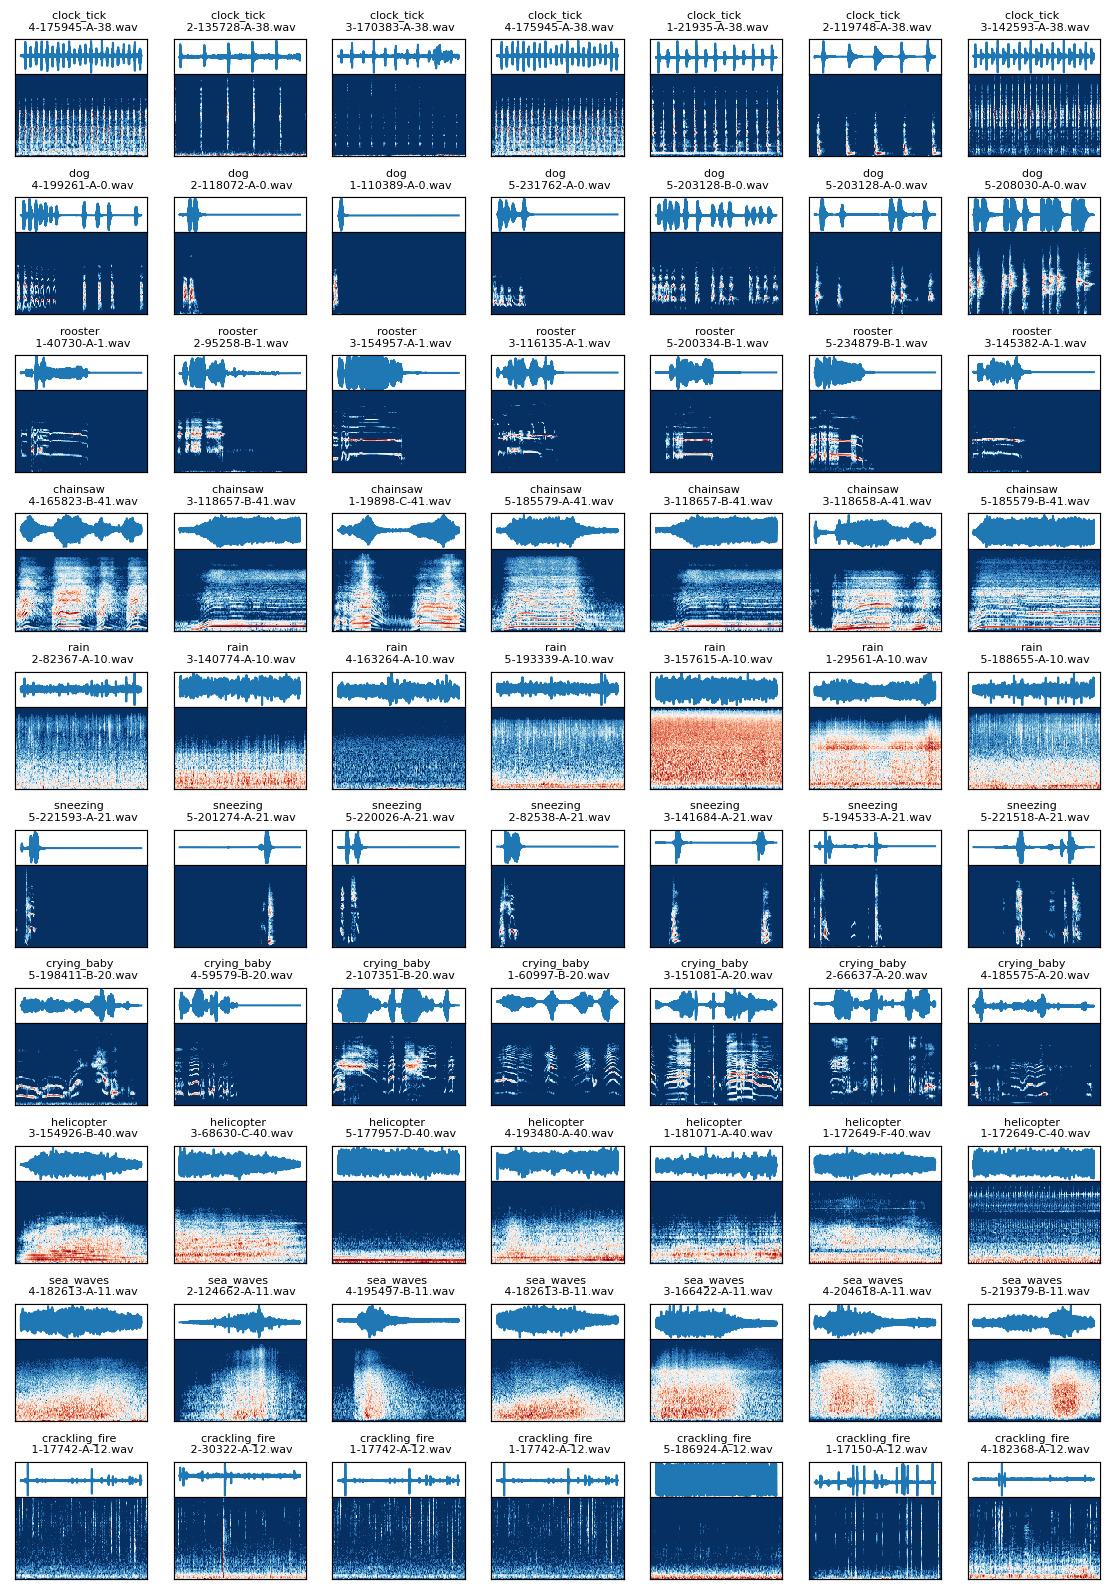

In [56]:

categories = audio_dt.category.unique()
clips_shown = 7
f, axes = plt.subplots(len(categories), clips_shown, figsize=(clips_shown * 2, len(categories) * 2), sharex=True, sharey=True)
f.subplots_adjust(hspace = 0.35)

for c, cat in enumerate(categories):
    plot_dt = audio_dt[audio_dt.category == cat].reset_index(drop=True)
    random_list = [random.randint(0,(plot_dt.shape[0] - 1)) for i in range(clips_shown)]
    plot_dt = plot_dt.iloc[random_list]
    for i, audio in enumerate(plot_dt.audio):
        plot_clip_overview(audio, axes[c, i], cat)

Here we see interesting patterns, for instance that there are certain sounds that tend to have very ripetitive sounds while other ones are an always on sound.
This shows to me that is not only the frequency that is important but also the slope of the presence of a particular frequency that will be important

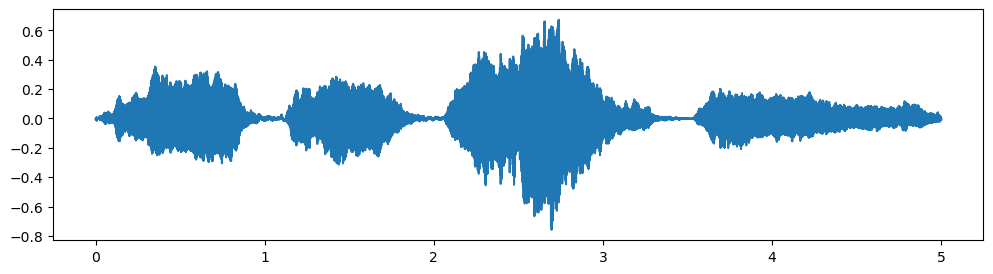

In [56]:
with audio_dt.audio.iloc[23].audio as audio:
    # print(audio.RATE)
    plt.figure(figsize=(12, 3))
    plt.plot(np.arange(len(audio.raw))/44100, audio.raw)

In [47]:
audio_dt.audio.iloc[23].audio